# Semi-Supervised Autoencoder for UNSW-NB15

This notebook trains a **Semi-Supervised Autoencoder** for intrusion detection on the **UNSW-NB15** dataset.

**Key Strategy:**
- **Hybrid Approach**: The model is trained primarily on **Normal** data to learn reconstruction, but also includes a small fraction of **Attack** data with a contrastive loss.
- **Objective**: Minimize reconstruction error for normal traffic while maximizing separation from known attacks.
- **Advantage**: Better decision boundary than purely unsupervised methods.

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path("../../").resolve()))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

sns.set_theme(style="whitegrid")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
CONFIG = {
    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "hidden_dims": [256, 128, 64],
    "latent_dim": 32,
    "dropout": 0.3,
    "patience": 15,
    "recon_weight": 0.3,
    "class_weight": 0.7,
}

CATEGORICAL_COLS = ['proto', 'service', 'state']
DROP_COLS = ['id', 'attack_cat']
LABEL_COL = 'label'
DATA_DIR = Path("../../data/raw/unsw-nb15")

def load_unsw_nb15(filepath, scaler=None, label_encoders=None, fit=True):
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    df = pd.read_csv(filepath)
    
    df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')
    y = df[LABEL_COL].values
    X = df.drop(columns=[LABEL_COL])
    
    if fit:
        label_encoders = {}
        for col in CATEGORICAL_COLS:
            if col in X.columns:
                le = LabelEncoder()
                X[col] = X[col].fillna('unknown').astype(str)
                X[col] = le.fit_transform(X[col])
                label_encoders[col] = le
    else:
        for col in CATEGORICAL_COLS:
            if col in X.columns:
                X[col] = X[col].fillna('unknown').astype(str)
                X[col] = X[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'unknown')
                if 'unknown' not in label_encoders[col].classes_:
                    label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'unknown')
                X[col] = label_encoders[col].transform(X[col])
    
    X = X.fillna(0).values.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    if fit:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
        X = np.clip(X, 0, 1)
        
    return X, y, scaler, label_encoders

In [3]:
try:
    # Load ALL training data
    X_train_full, y_train_full, scaler, label_encoders = load_unsw_nb15(
        DATA_DIR / "UNSW_NB15_training-set.csv", fit=True
    )
    
    X_test, y_test, _, _ = load_unsw_nb15(
        DATA_DIR / "UNSW_NB15_testing-set.csv", 
        scaler=scaler, label_encoders=label_encoders, fit=False
    )
    
    # Prepare Semi-Supervised Data
    # Use ALL Normal data + 30% of Attack data for training
    normal_mask = (y_train_full == 0)
    attack_mask = (y_train_full == 1)
    
    X_normal = X_train_full[normal_mask]
    y_normal = y_train_full[normal_mask]
    X_attack = X_train_full[attack_mask]
    y_attack = y_train_full[attack_mask]
    
    n_attack_train = int(0.3 * len(X_attack))
    indices = np.random.permutation(len(X_attack))
    
    X_attack_train = X_attack[indices[:n_attack_train]]
    y_attack_train = y_attack[indices[:n_attack_train]]
    
    X_train = np.vstack([X_normal, X_attack_train])
    y_train = np.concatenate([y_normal, y_attack_train])
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(X_train))
    X_train = X_train[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Validation Split of Mixed Data
    val_size = int(0.1 * len(X_train))
    X_val = X_train[:val_size]
    y_val = y_train[:val_size]
    X_train = X_train[val_size:]
    y_train = y_train[val_size:]
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    print(f"Attack samples in training: {n_attack_train:,}")

except FileNotFoundError:
    print("❌ Dataset not found!")

Train: (45540, 42), Val: (5059, 42), Test: (175341, 42)
Attack samples in training: 13,599


## 2. Model Definition
This autoencoder has a classification head attached to the latent space.

In [4]:
class SemiSupervisedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], latent_dim=32, dropout=0.3):
        super().__init__()
        
        # Encoder
        self.input_bn = nn.BatchNorm1d(input_dim)
        layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(dropout)
            ])
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, latent_dim))
        self.encoder = nn.Sequential(*layers)
        
        # Decoder
        layers = []
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(dropout * 0.5)
            ])
            in_dim = h_dim
        layers.extend([
            nn.Linear(in_dim, input_dim),
            nn.Sigmoid()
        ])
        self.decoder = nn.Sequential(*layers)
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
    def forward(self, x):
        x_norm = self.input_bn(x)
        z = self.encoder(x_norm)
        x_recon = self.decoder(z)
        logits = self.classifier(z)
        return x_recon, z, logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'X_train' in globals():
    model = SemiSupervisedAutoencoder(
        input_dim=X_train.shape[1],
        hidden_dims=CONFIG["hidden_dims"],
        latent_dim=CONFIG["latent_dim"],
        dropout=CONFIG["dropout"]
    ).to(device)
    print(f"Model on {device}")

Model on cuda


In [5]:
# Loss Functions
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor(len(y_train) / (2 * class_counts)).to(device)

criterion_recon = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), 
    batch_size=CONFIG["batch_size"], shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)), 
    batch_size=CONFIG["batch_size"], shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), 
    batch_size=CONFIG["batch_size"], shuffle=False
)

c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        x_recon, z, logits = model(X_batch)
        
        loss_recon = criterion_recon(x_recon, X_batch)
        loss_class = criterion_class(logits, y_batch)
        loss = CONFIG["recon_weight"] * loss_recon + CONFIG["class_weight"] * loss_class
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, pred = logits.max(1)
        total += y_batch.size(0)
        correct += pred.eq(y_batch).sum().item()
        
    return total_loss/len(loader), correct/total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            x_recon, z, logits = model(X_batch)
            
            loss_recon = criterion_recon(x_recon, X_batch)
            loss_class = criterion_class(logits, y_batch)
            loss = CONFIG["recon_weight"] * loss_recon + CONFIG["class_weight"] * loss_class
            
            total_loss += loss.item()
            _, pred = logits.max(1)
            total += y_batch.size(0)
            correct += pred.eq(y_batch).sum().item()
            
    return total_loss/len(loader), correct/total

In [7]:
if 'X_train' in globals():
    best_val_acc = 0
    
    for epoch in range(CONFIG["epochs"]):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "../../results/models/autoencoder_unsw.pt")
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 5 | Train Acc: 0.9375 | Val Acc: 0.9583
Epoch 10 | Train Acc: 0.9453 | Val Acc: 0.9488
Epoch 15 | Train Acc: 0.9522 | Val Acc: 0.9652
Epoch 20 | Train Acc: 0.9534 | Val Acc: 0.9526
Epoch 25 | Train Acc: 0.9555 | Val Acc: 0.9658
Epoch 30 | Train Acc: 0.9575 | Val Acc: 0.9674
Epoch 35 | Train Acc: 0.9564 | Val Acc: 0.9684
Epoch 40 | Train Acc: 0.9559 | Val Acc: 0.9666
Epoch 45 | Train Acc: 0.9563 | Val Acc: 0.9624
Epoch 50 | Train Acc: 0.9560 | Val Acc: 0.9658


C:\Users\musab\AppData\Local\Temp\ipykernel_52552\1386865408.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../results/models/autoe

Test Accuracy: 0.8815
              precision    recall  f1-score   support

      Normal       0.74      0.98      0.84     56000
      Attack       0.99      0.84      0.91    119341

    accuracy                           0.88    175341
   macro avg       0.86      0.91      0.87    175341
weighted avg       0.91      0.88      0.88    175341



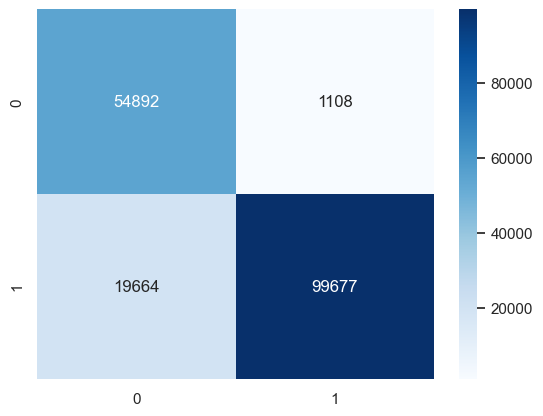

4155

In [8]:
if 'X_train' in globals():
    model.load_state_dict(torch.load("../../results/models/autoencoder_unsw.pt"))
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            _, _, logits = model(X_batch)
            _, pred = logits.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Attack']))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
    plt.show()

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()